> **Regresion with Different Optimizers**



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print("PyTorch version {}".format(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))


PyTorch version 1.9.0+cpu
device: cpu


> **Dataset**

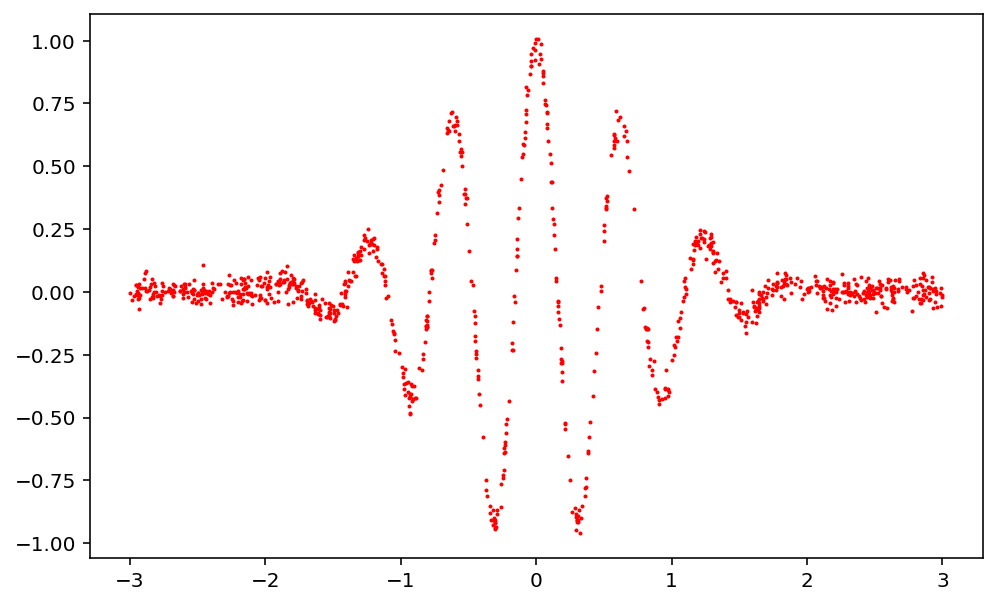

DONE. 


In [3]:
n_data = 1000
x_numpy = -3+6*np.random.rand(n_data,1)
y_numpy = np.exp(-(x_numpy**2))*np.cos(10*x_numpy) + 3e-2*np.random.randn(n_data,1)
plt.figure(figsize=(8,5))
plt.plot(x_numpy,y_numpy,'r.',ms=2)
plt.show()
x_torch = torch.Tensor(x_numpy).to(device)
y_torch = torch.Tensor(y_numpy).to(device)
print("DONE. ")

> **DEFINE MODEL**

In [14]:
class Model(nn.Module):
  def __init__(self,name='mlp',xdim=1,hdims=[16,16],ydim=1):
    super(Model, self).__init__()
    self.name = name
    self.xdim = xdim
    self.hdims = hdims
    self.ydim = ydim

    self.layers= []
    prev_hdim = self.xdim
    for hdim in self.hdims:
      self.layers.append(nn.Linear(prev_hdim,hdim,bias=True))
      self.layers.append(nn.Tanh()) # activation Function
      prev_hdim = hdim
    #Final layer (without activation Function)
    self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

    self.net = nn.Sequential()
    for l_idx, layer in enumerate(self.layers):
      layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
      self.net.add_module(layer_name,layer)
    
    self.init_param()

  def init_param(self):
    for m in self.modules():
      if isinstance(m,nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)
  
  def forward(self, x):
    return self.net(x)


>**여러가지 optim으로 model 정의하기**

In [15]:
LEARNING_RATE = 1e-2

# 3개의 모델 인스턴스 생성
model_sgd = Model(name='mlp_sgd',xdim=1, hdims=[64,64],ydim=1).to(device)
model_momentum = Model(name='mlp_momentum',xdim=1, hdims=[64,64],ydim=1).to(device)
model_adam = Model(name='mlp_adam',xdim=1, hdims=[64,64],ydim=1).to(device)

loss = nn.MSELoss()

# 3개의 Optimizers 정의
optm_sgd = optim.SGD(model_sgd.parameters(),lr=LEARNING_RATE)
optm_momentum = optim.SGD(model_momentum.parameters(),lr=LEARNING_RATE, momentum=0.9)
optm_adam = optim.Adam(model_adam.parameters(),lr=LEARNING_RATE)
print("Done")



Done


>**Check Parameters**

In [17]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name,param) in enumerate(model_sgd.named_parameters()):
  if param.requires_grad:
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
    print("    val:%s"%(param_numpy.reshape(-1)[:5])) #앞에서 5개 예시
  
  print("Total number of parameters:[%s]."%format(n_param,',d'))

[0] name:[net.linear_00.weight] shape:[(64, 1)].
    val:[ 1.301 -0.091 -2.365 -0.932 -2.277]
Total number of parameters:[64].
[1] name:[net.linear_00.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[128].
[2] name:[net.linear_02.weight] shape:[(64, 64)].
    val:[-0.047  0.005  0.248 -0.003 -0.283]
Total number of parameters:[4,224].
[3] name:[net.linear_02.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[4,288].
[4] name:[net.linear_04.weight] shape:[(1, 64)].
    val:[ 0.186 -0.016  0.244 -0.045 -0.079]
Total number of parameters:[4,352].
[5] name:[net.linear_04.bias] shape:[(1,)].
    val:[0.]
Total number of parameters:[4,353].


> ** MODEL TRAININIG**

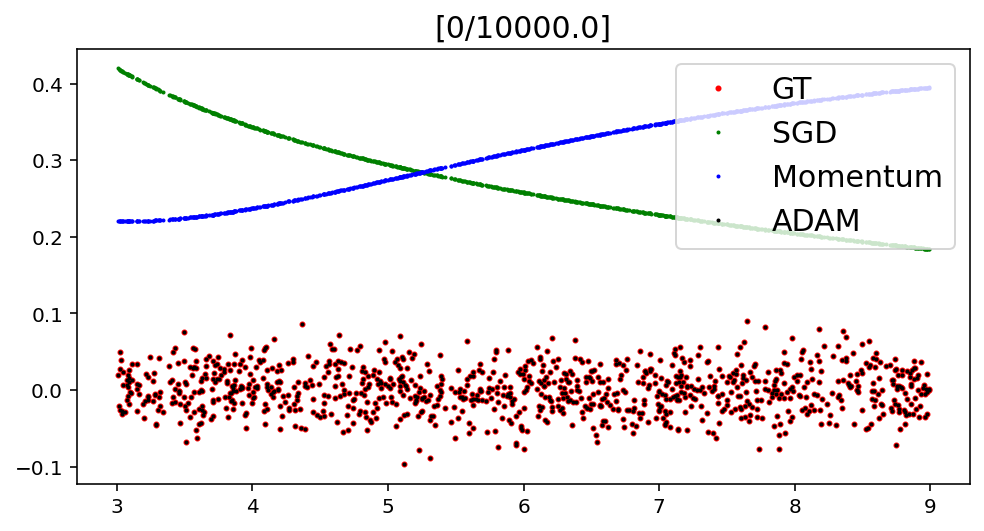

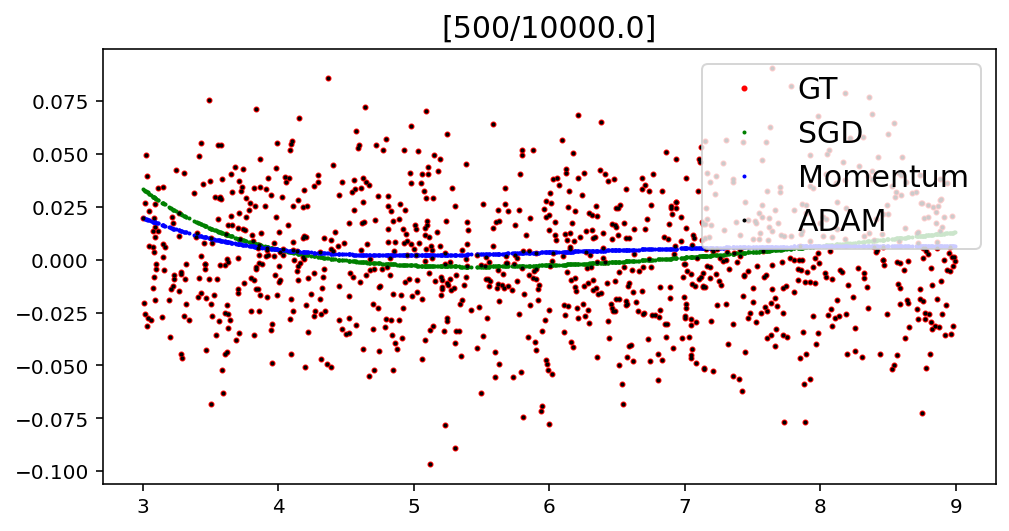

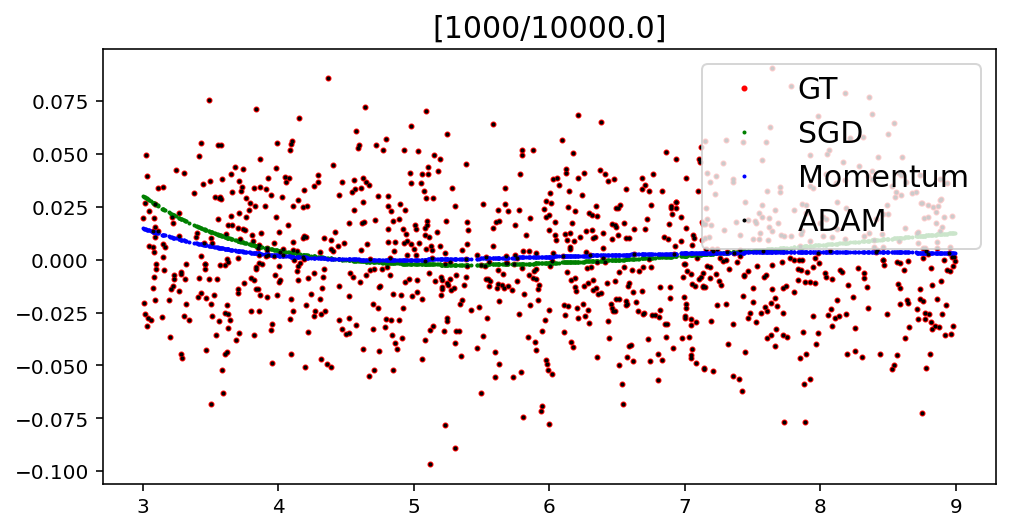

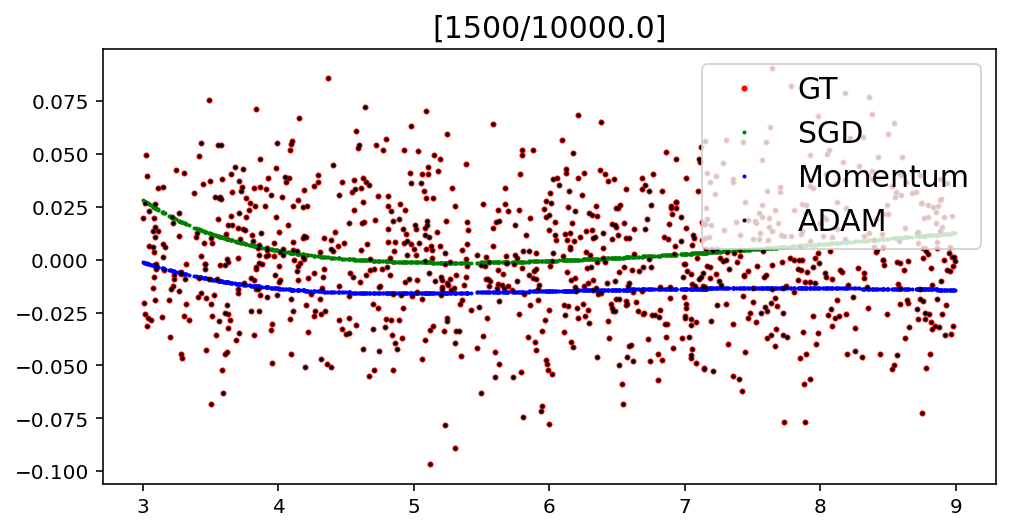

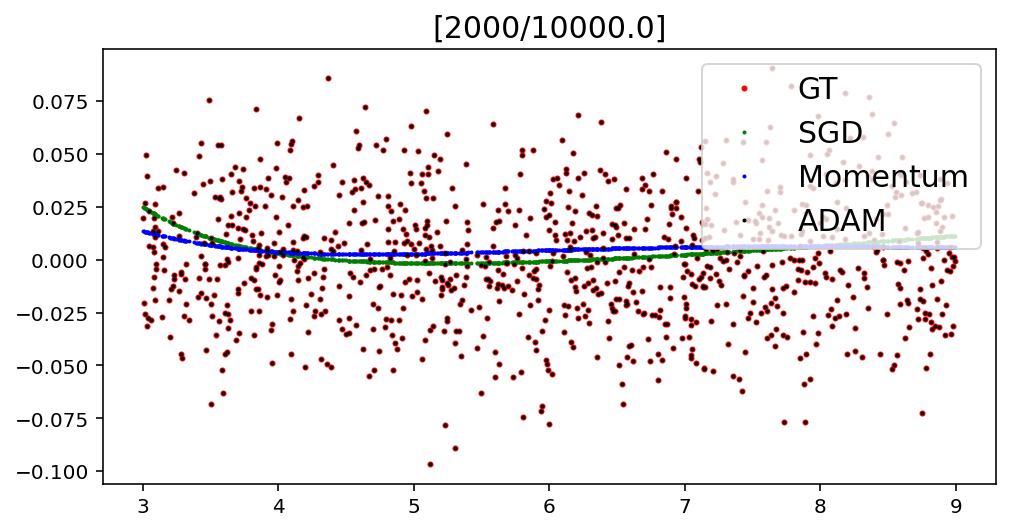

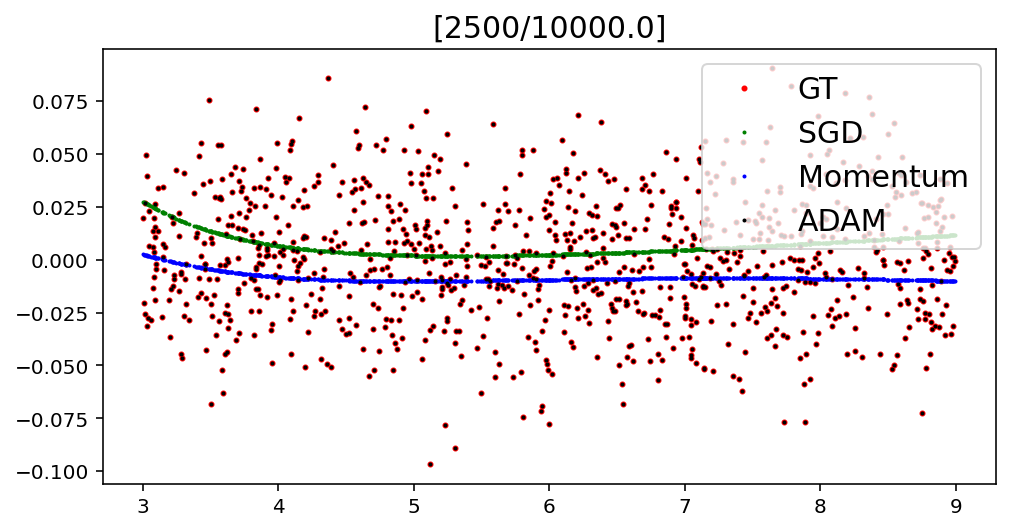

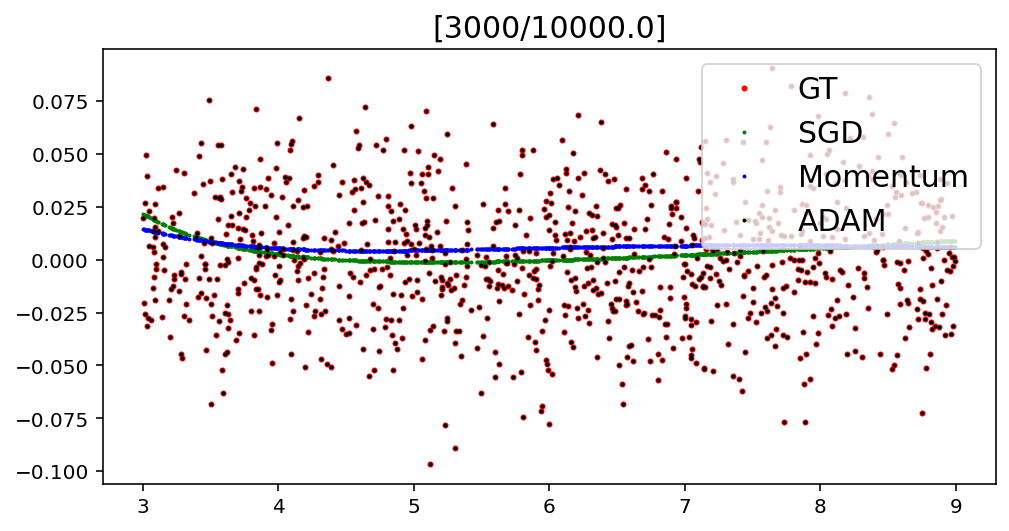

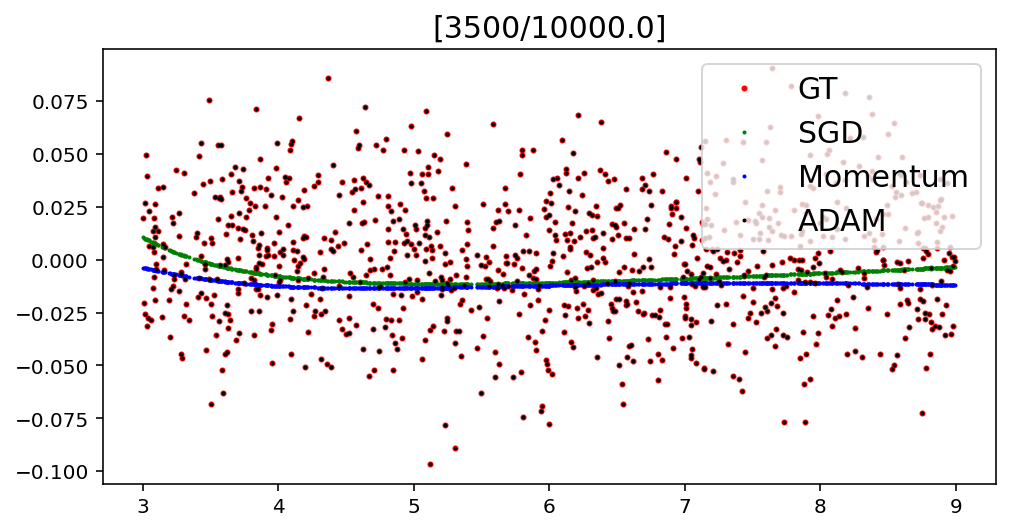

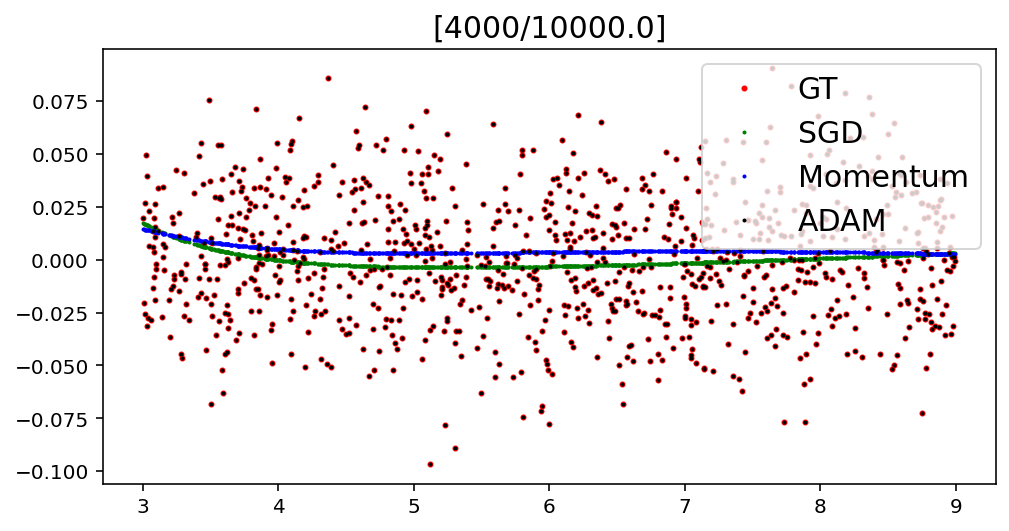

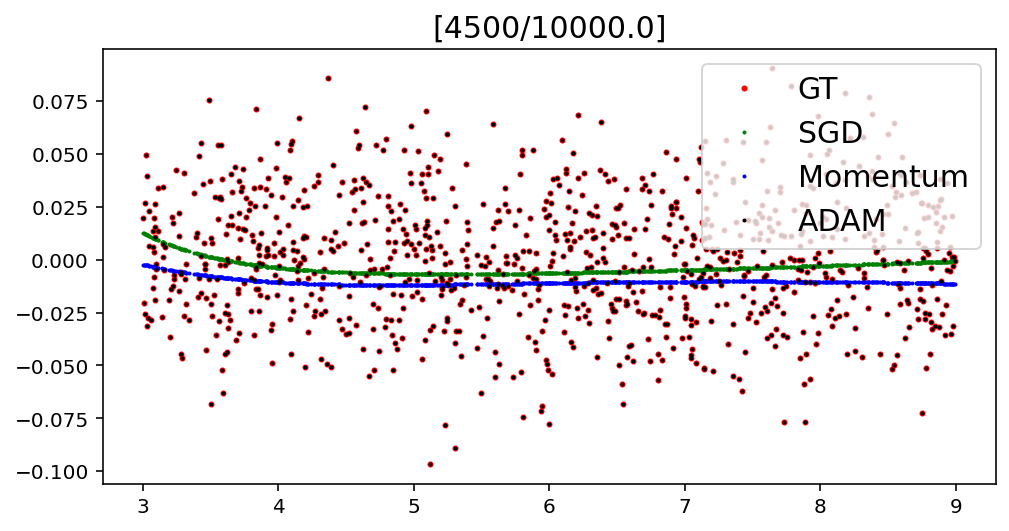

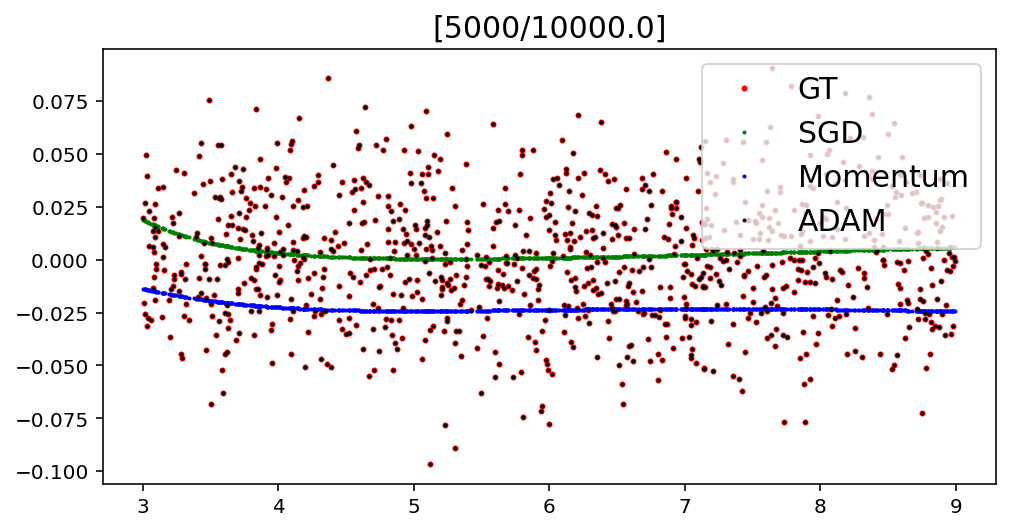

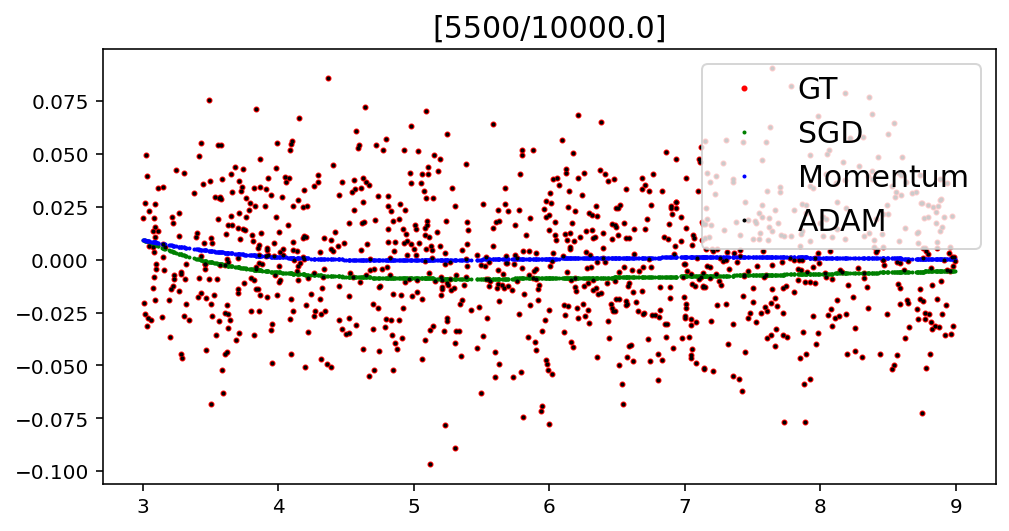

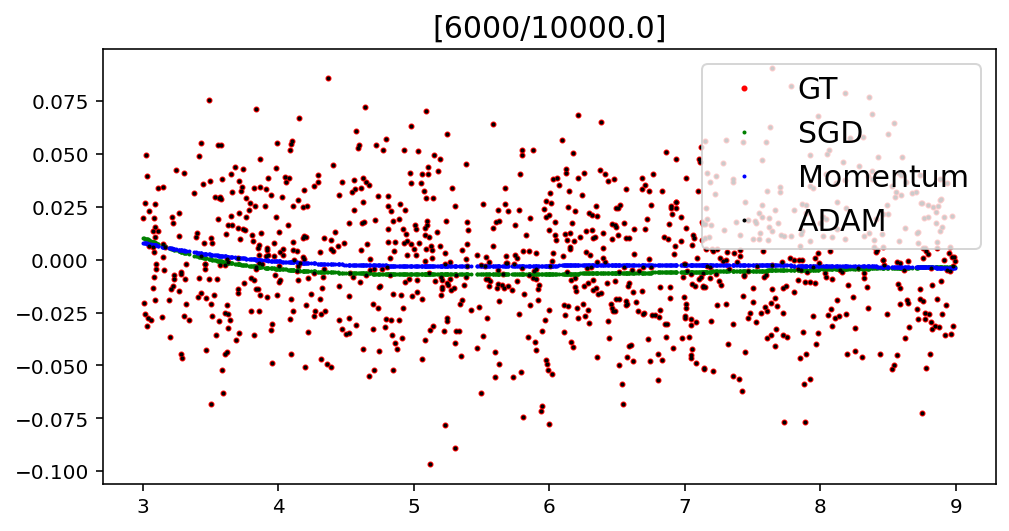

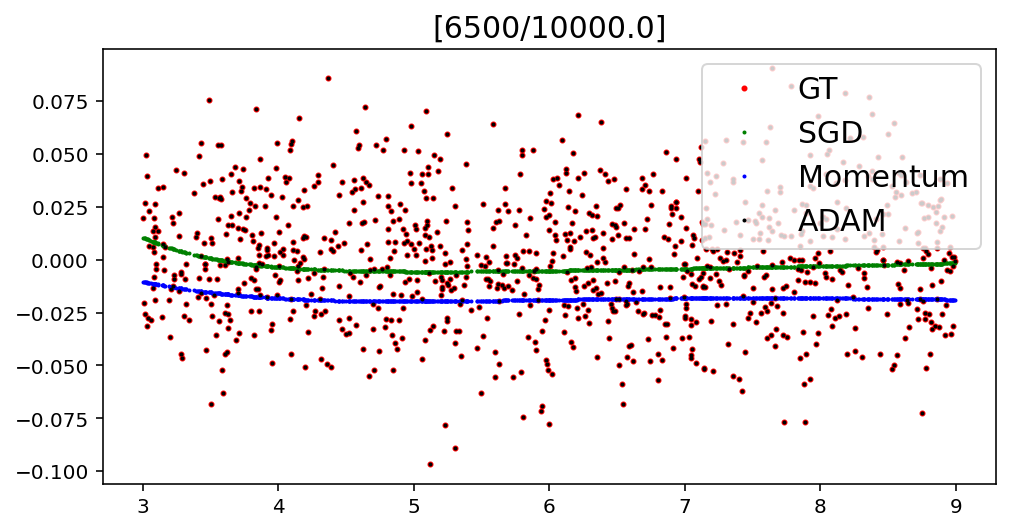

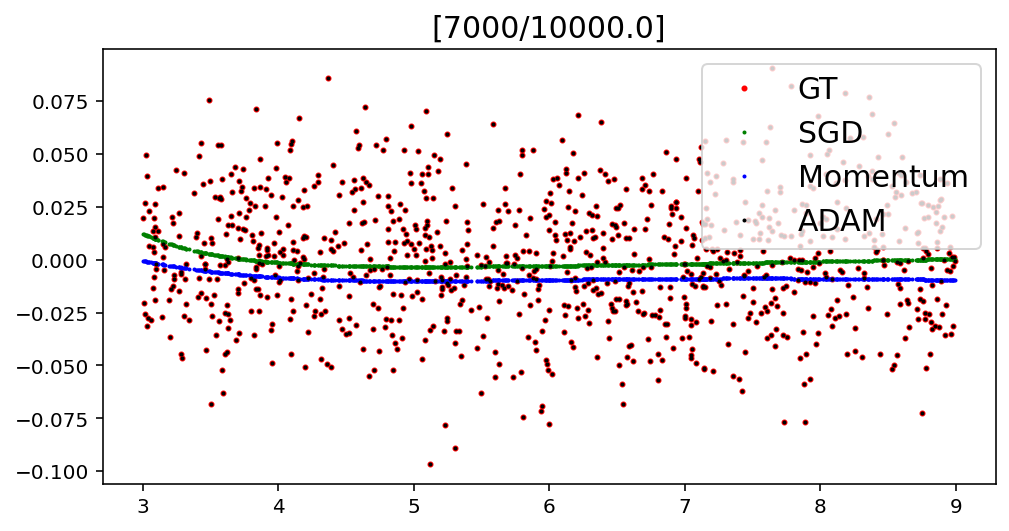

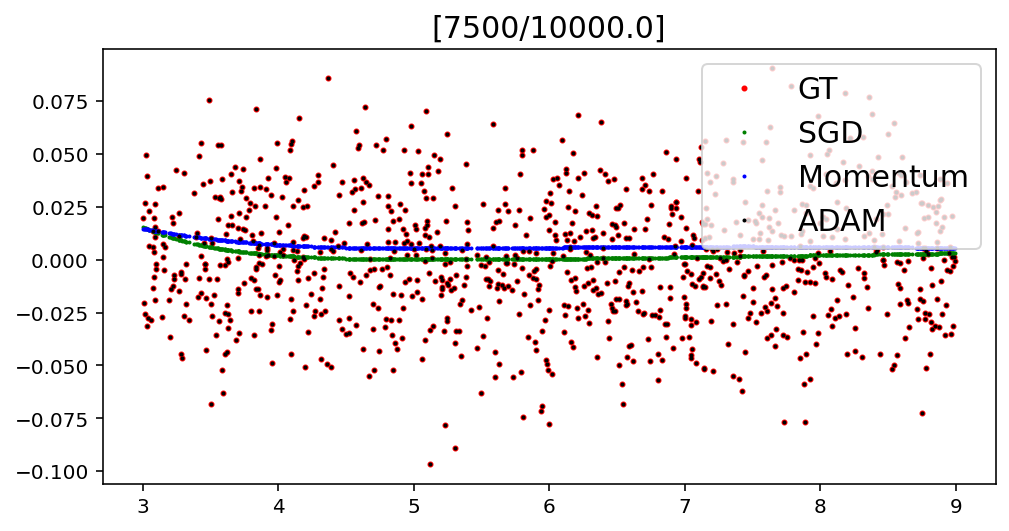

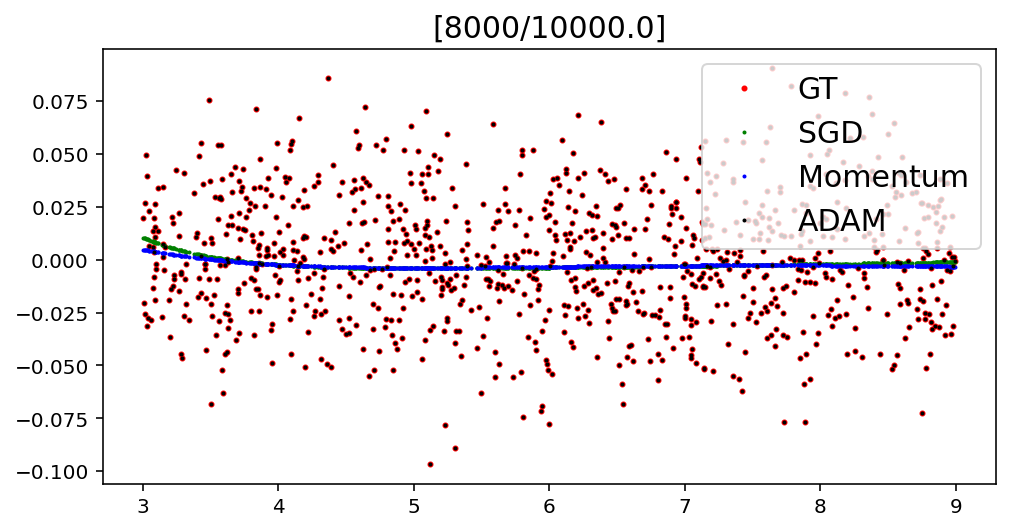

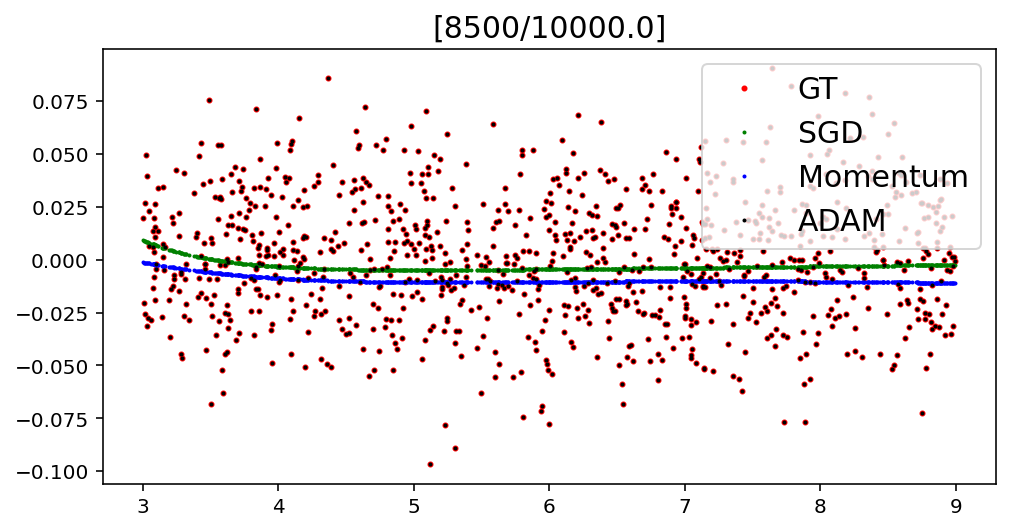

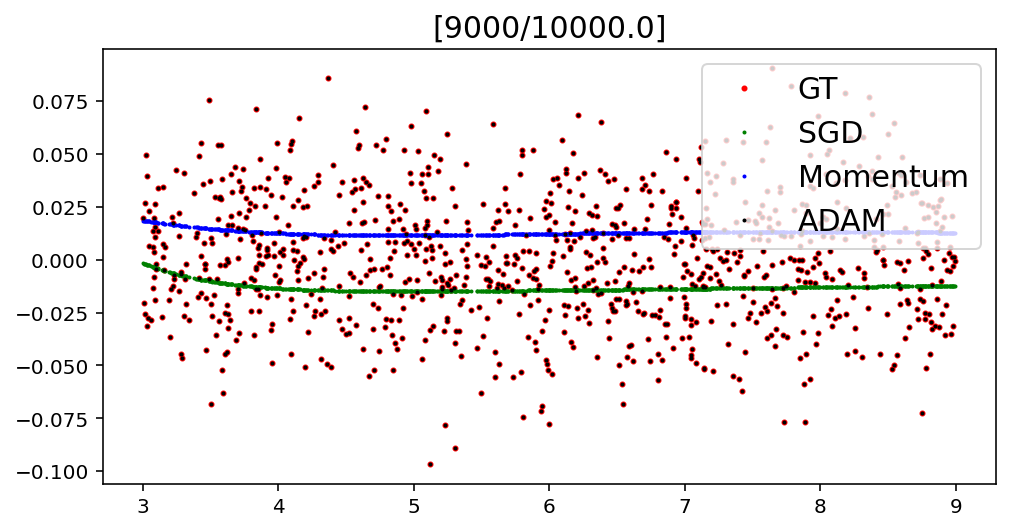

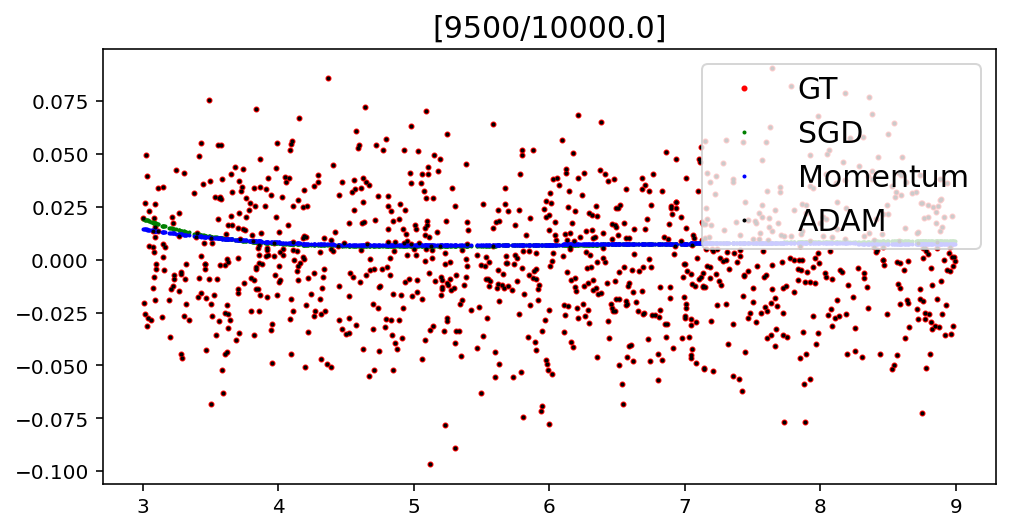

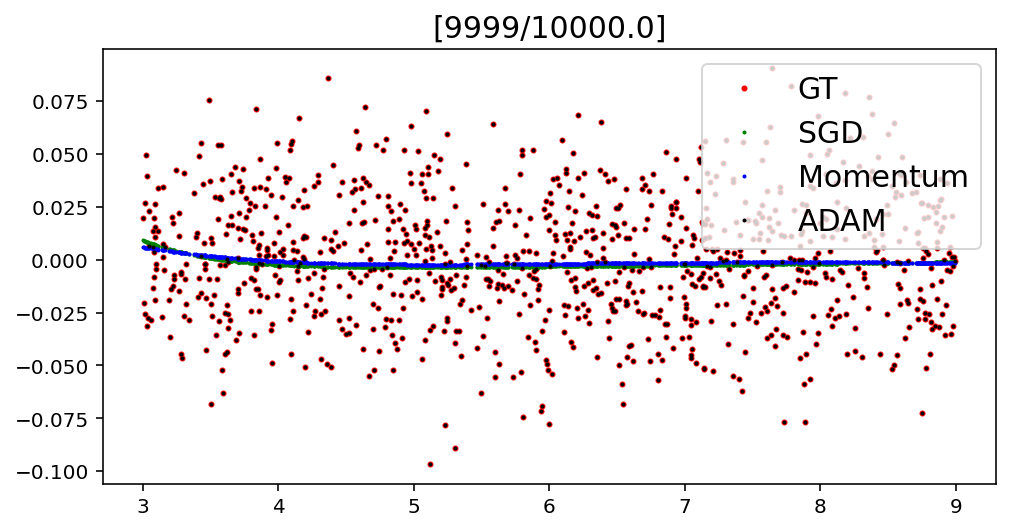

DONE


In [24]:
MAX_ITER, BATCH_SIZE, PLOT_EVERY = 1e4,64,500

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train()
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)):
  r_idx = np.random.permutation(n_data)[:BATCH_SIZE]
  batch_x, batch_y = x_torch[r_idx],y_torch[r_idx]

  #ADAM
  y_pred_adam = model_adam.forward(batch_x)
  loss_adam = loss(y_pred_adam,batch_y)
  optm_adam.zero_grad()
  loss_adam.backward()
  optm_adam.step()

  #MOMENTUM
  y_pred_momentum = model_momentum.forward(batch_x)
  loss_momentum = loss(y_pred_momentum, batch_y)
  optm_momentum.zero_grad()
  loss_momentum.backward()
  optm_momentum.step()

  #SGD
  y_pred_sgd = model_sgd.forward(batch_x)
  loss_sgd = loss(y_pred_sgd, batch_y)
  optm_sgd.zero_grad()
  loss_sgd.backward()
  optm_sgd.step()

  #Plot
  if ((it%PLOT_EVERY == 0)) or (it==0) or (it==MAX_ITER-1):
    with torch.no_grad():
      y_sgd_numpy = model_sgd.forward(x_torch).cpu().detach().numpy()
      y_momentum_numpy = model_momentum.forward(x_torch).cpu().detach().numpy()
      y_adam_numpy = model_adam.forward(x_torch).cpu().detach().numpy()

      plt.figure(figsize=(8,4))
      plt.plot(x_numpy, y_numpy, 'r.',ms=4,label='GT')
      plt.plot(x_numpy, y_sgd_numpy, 'g.',ms=2,label='SGD')
      plt.plot(x_numpy, y_momentum_numpy, 'b.',ms=2,label='Momentum')
      plt.plot(x_numpy, y_numpy, 'k.',ms=2,label='ADAM')
      plt.title("[{}/{}]".format(it,MAX_ITER),fontsize=15)
      plt.legend(loc='upper right',fontsize=15)
      plt.show()
  
print("DONE")



>tip

*lossfunction().backward()*와 *optimizer.step()*의 연관성

-> https://discuss.pytorch.org/t/how-are-optimizer-step-and-loss-backward-related/7350
